In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved.
# Licensed under the MIT License.

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from model import Selection
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# settings
rng_seed = 42  # control reproducibility
ran_sta = 3
method = "lasso"
exp_to_run = "diagnosis"  # survival or diagnosis

In [3]:
# catch setting errors
assert method == "lasso"
assert exp_to_run in ["survival", "diagnosis"]

In [4]:
if exp_to_run == "survival":
    # read data for survival prediction
    meta_lipi = pd.read_excel('./data/metabolomics and lipidomics data.xlsx', sheet_name='Sheet1')
    clini = pd.read_excel('./data/metabolomics and lipidomics data.xlsx', sheet_name='Sheet3')

    # select data: input X and output labels
    years = 7  # select patients with survival time larger than this value, -1 to use all data
    patient = clini.loc[clini.apply(lambda x: str(x["Patient"]).startswith("HCM"), axis=1)]
    print("Max Survival time after surgery (year): ", max(patient["Survival time after surgery (year)"]))
    patient = patient.loc[(patient["Survival time after surgery (year)"]>years)|(patient["cardiovascular death"]==0)]
    patient = patient.loc[~patient["cardiovascular death"].isnull()]
    labels = patient["cardiovascular death"].values.reshape(-1)
    X = meta_lipi[patient["Patient"]].T.values
    metas = list(meta_lipi.Metabolites)
    print("input X:", type(X), X.shape)
    print("output labels:", type(labels), labels.shape)

    # train test split
    patient_id = patient["Patient"].values.tolist()
    train_lis = []
    test_lis = []
    for i, x in enumerate(patient_id):
        j = int(x[4:])
        if (labels[i]==1 and j<53) or (j<220 and labels[i]==0):
            # print("train", labels[i], x)
            train_lis.append(i)
        else:
            # print("test", labels[i], x)
            test_lis.append(i)
    Xtrain, Xtest = X[train_lis], X[test_lis]
    ytrain, ytest = labels[train_lis], labels[test_lis]

    print("train test info:")
    print("all, live-death", np.unique(labels,return_counts=True))
    print("train, live-death", np.unique(ytrain,return_counts=True))
    print("test, live-death", np.unique(ytest,return_counts=True))

In [5]:
if exp_to_run == "diagnosis":
    # read data for diagnosis prediction
    plasma_df = pd.read_excel('./data/Normalized HCM plasma metabolomics data.xlsx', sheet_name='Sheet1')

    # input X and output labels
    X = plasma_df.T.values[1:]
    labels = []
    for c in plasma_df.columns[1:]:
        if c.startswith("C"):
            labels.append(0.0)
        elif c.startswith("FW"):
            labels.append(1.0)
        else:
            raise ValueError
    labels = np.array(labels)
    metas = list(plasma_df.T.values[0])
    X = X.astype(np.float32)
    labels = labels.astype(np.float32)

    print("input X:", type(X), X.shape)
    print("output labels:", type(labels), labels.shape)

    # random train valid test seperation
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, labels, test_size=0.33, random_state=ran_sta)

    print("train test info:")
    print("all, normal-hcm", np.unique(labels,return_counts=True))
    print("train, normal-hcm", np.unique(ytrain,return_counts=True))
    print("test, normal-hcm", np.unique(ytest,return_counts=True))

input X: <class 'numpy.ndarray'> (203, 142)
output labels: <class 'numpy.ndarray'> (203,)
train test info:
all, normal-hcm (array([0., 1.], dtype=float32), array([ 60, 143]))
train, normal-hcm (array([0., 1.], dtype=float32), array([40, 96]))
test, normal-hcm (array([0., 1.], dtype=float32), array([20, 47]))


In [6]:
def test(model, Xtest, ytest, metric='auc'):
    pred = model.predict(Xtest)
    prob = model.predict_proba(Xtest)
    s = f1_score(ytest, pred)
    s1 = roc_auc_score(ytest, prob[:,-1])
    print("f1 score:", s)
    print("auroc score:", s1)
    return (s,s1)
         
def train_test(Xtrain, ytrain, Xtest, ytest, test_fn="RF", seed=12306, metric='auc'):
    model = RF(random_state=seed)
    model.fit(Xtrain, ytrain)
    print("evaluate on train set:")
    test(model, Xtrain, ytrain, metric)
    print("evaluate on test set:")
    s = test(model, Xtest, ytest, metric)
    return model, s

In [7]:
class ArgsClass:
    def __init__(self, k=5, alpha=0.05):
        self.k=k
        self.alpha=alpha
args=ArgsClass(k=10, alpha=0.001)
sel = Selection(method, args)
sel.fit(Xtrain, ytrain)  # select on whole training set
mb = sel.mb_
print("selected feature index: ", mb)
print("selected meta names: ", [metas[x] for x in mb])
print("with selected featues:")
model, raw = train_test(sel.transform(Xtrain), ytrain, sel.transform(Xtest), ytest, test_fn="RF")
y_pred = model.predict_proba(sel.transform(Xtest))[:,-1]
# feature importance
print("feature importance")
imp = model.feature_importances_
print(type(imp), imp)

selected feature index:  [32 37 56 73 89]
selected meta names:  ['8:0-Carnitine', 'Creatine', 'Hypoxanthine', 'Phenylalanine', 'Tryptophan']
with selected featues:
evaluate on train set:
f1 score: 1.0
auroc score: 1.0
evaluate on test set:
f1 score: 0.9462365591397849
auroc score: 0.976063829787234
feature importance
<class 'numpy.ndarray'> [0.34039962 0.10576926 0.27412452 0.11698484 0.16272176]


In [8]:
n_bootstraps = 1000
def CI(y_true, y_pred):
    bootstrapped_scores = []
    print("auroc score:", roc_auc_score(y_true, y_pred))
    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
        #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
    print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
        confidence_lower, confidence_upper))
    return confidence_lower, confidence_upper


auroc score: 0.976063829787234
Confidence interval for the score: [0.947 - 0.998]


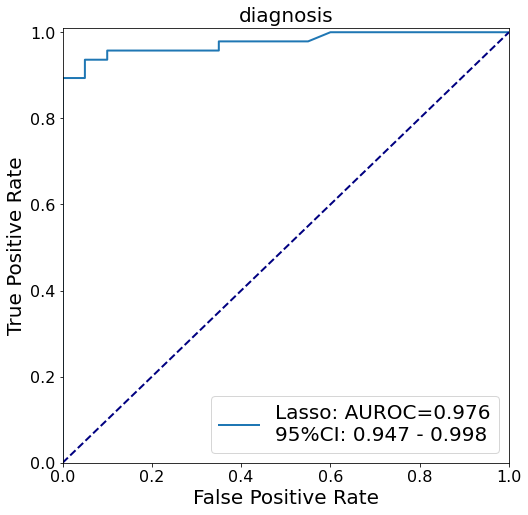

In [9]:
plt.figure(figsize=(8, 8))
fpr, tpr, _ = roc_curve(ytest, y_pred)
r , l = CI(ytest, y_pred)
tex = 'Lasso: AUROC={:0.3f}\n95%CI: {:0.3f} - {:0.3f}'.format(raw[1],r,l)
plt.plot(fpr, tpr, lw=2, label=tex)
    
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate', fontdict={'size'   : 20})
plt.ylabel('True Positive Rate', fontdict={'size'   : 20})
plt.title(exp_to_run, fontdict={'size'   : 20})
plt.yticks(size = 16)
plt.xticks(size = 16)  
plt.legend(loc="lower right",fontsize=20)
plt.savefig("./figures/{}_roc.pdf".format(exp_to_run))
plt.show()

In [10]:
from sklearn.metrics import precision_recall_curve, auc
def CI_pr(y_true, y_pred):
    bootstrapped_scores = []
    precision, recall, thresholds = precision_recall_curve(ytest, y_pred)
    aupr = auc(recall, precision)
    print("auprc socre:", aupr)
    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
        
        precision, recall, thresholds = precision_recall_curve(y_true[indices], y_pred[indices])
        score = auc(recall, precision)
        bootstrapped_scores.append(score)
        #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    print(len(sorted_scores))
    confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
    print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
        confidence_lower, confidence_upper))
    return confidence_lower, confidence_upper

auprc socre: 0.9910635406707288
1000
Confidence interval for the score: [0.980 - 0.999]


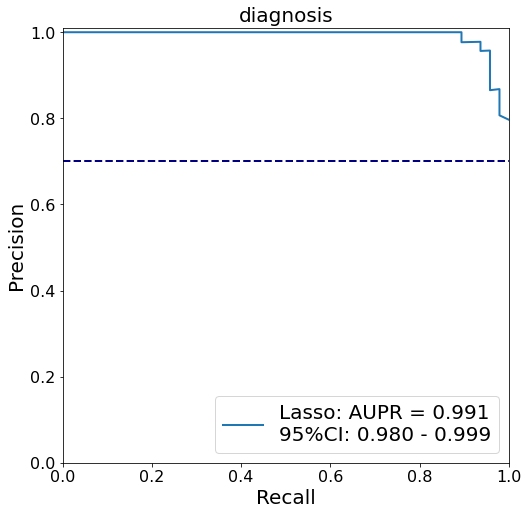

In [11]:
plt.figure(figsize=(8, 8))
precision, recall, thresholds = precision_recall_curve(ytest, y_pred)
aupr = auc(recall, precision)
r, l = CI_pr(ytest, y_pred)
tex = 'Lasso: AUPR = {:0.3f}\n95%CI: {:0.3f} - {:0.3f}'.format(aupr,r,l)
plt.plot(recall, precision, lw=2, label=tex)

fr = len(ytest[ytest==1])/len(ytest)
plt.plot([0, 1], [fr,fr], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('Recall', fontdict={'size'   : 20})
plt.ylabel('Precision', fontdict={'size'   : 20})
plt.title(exp_to_run, fontdict={'size'   : 20})
plt.yticks(size = 16)
plt.xticks(size = 16)  
plt.legend(loc="lower right",fontsize=20)
plt.savefig("./figures/{}_prc.pdf".format(exp_to_run))
plt.show()

In [12]:
# cross validation
class ArgsClass:
    def __init__(self, k=5, alpha=0.05):
        self.k=k
        self.alpha=alpha
args=ArgsClass(k=20, alpha=0.001)
sel = Selection(method, args)
ratio = 0.5
sel.fit_repeat_cv(Xtrain, ytrain, metas, threshold_ratio=ratio, random_state=rng_seed)  # cross validation on trainig set
mb = sel.mb_
print("selection results with selected times >= {} in 50 times:".format(ratio))
print("selected feature index: ", mb)
print("selected meta names: ", [metas[x] for x in mb])
print("with selected features:")
model, raw = train_test(sel.transform(Xtrain), ytrain, sel.transform(Xtest), ytest, test_fn="RF") 

repeated corss validation
all selected features with selected times:
feature_index: 56, meta nema: Hypoxanthine, selected times:50
feature_index: 73, meta nema: Phenylalanine, selected times:50
feature_index: 89, meta nema: Tryptophan, selected times:50
feature_index: 37, meta nema: Creatine, selected times:49
feature_index: 32, meta nema: 8:0-Carnitine, selected times:40
feature_index: 75, meta nema: Proline, selected times:12
feature_index: 23, meta nema: Carnitine, selected times:2
selection results with selected times >= 0.5 in 50 times:
selected feature index:  [32 37 56 73 89]
selected meta names:  ['8:0-Carnitine', 'Creatine', 'Hypoxanthine', 'Phenylalanine', 'Tryptophan']
with selected features:
evaluate on train set:
f1 score: 1.0
auroc score: 1.0
evaluate on test set:
f1 score: 0.9462365591397849
auroc score: 0.976063829787234
